# Read in the data

In [2]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

### Plotting histogramme corr 

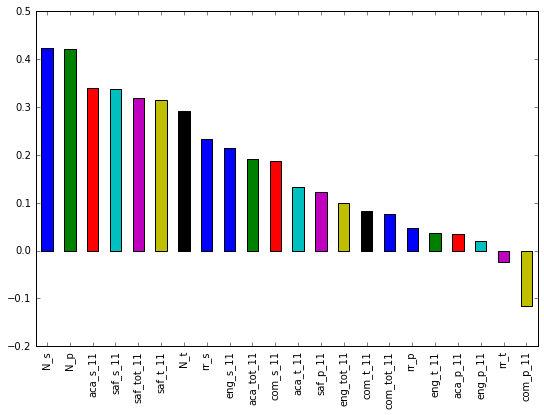

In [14]:
correlations[survey_fields].sort_values(ascending = False).plot.bar(figsize=(9,6))


Considering a correlation value >0.3, There is a strong correlation between the SAT scores and [['N_s'], ['N_p'], ['aca_s_11'], ['saf_s_11'], ['saf_tot_1a1'],['saf_t_11']]. 
- N_s: Number of student respondents 
- N_p: Number of parent respondents
- aca_s_11: Academic expectations score based on student responses
- saf_s_11: Safety and Respect score based on student responses
- saf_tot_1a1: Safety and Respect total score for question 
- saf_t_11: Safety and Respect score based on teacher responses
- N_t:Number of teacher respondents


SAT score and number of respondents( students, parent and teacher) kind of related  => communauty more engaged might explain this.

In [32]:
for col in correlations[survey_fields].sort_values(ascending = False).index.str.split(',')[0:7]:
    print(col)
    
    
    
    

['N_s']
['N_p']
['aca_s_11']
['saf_s_11']
['saf_tot_11']
['saf_t_11']
['N_t']


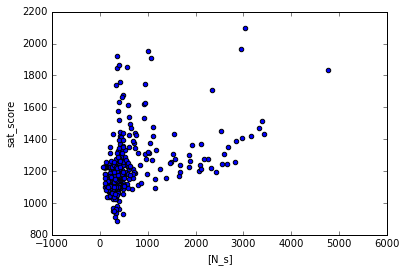

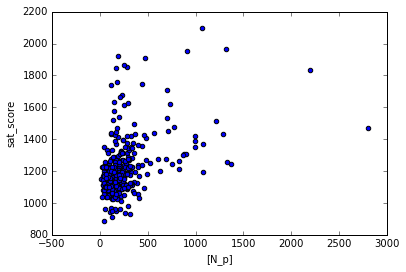

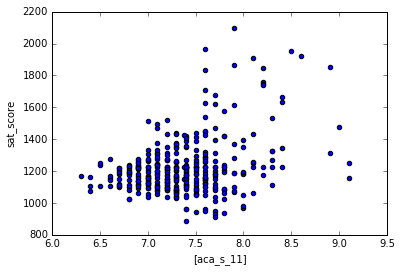

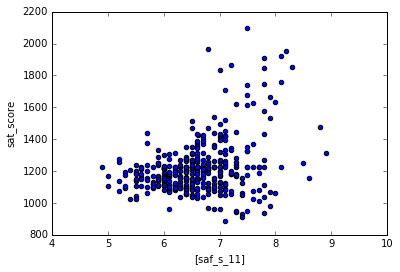

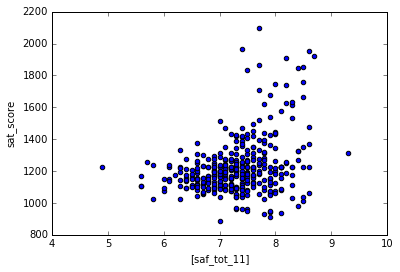

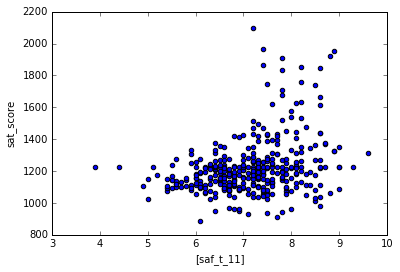

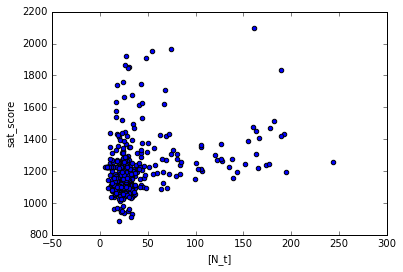

In [33]:
for col in correlations[survey_fields].sort_values(ascending = False).index.str.split(',')[0:7]:
    combined.plot.scatter(x=col,y='sat_score')

### Safety scores 

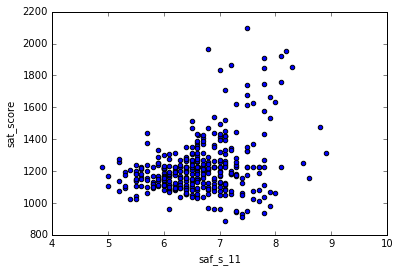

In [29]:
combined.plot.scatter(x='saf_s_11',y='sat_score')

- Effectively, the plot reveals a somewaht relation between the feeling of safety and the sat_score but it is not enough at all to draw conclusion, what is meant by the feeling of security
- the number of respondent has a higher correlation with the sat_score, why?? could it be link with the safety score => a correlation between the two features should be consider.

####  safety score by district

In [41]:
# average safety score by districts 
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

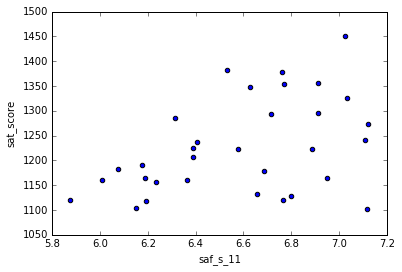

In [43]:
districts.plot.scatter(x='saf_s_11',y='sat_score')

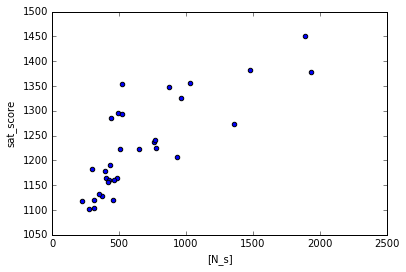

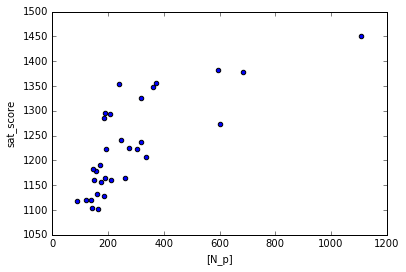

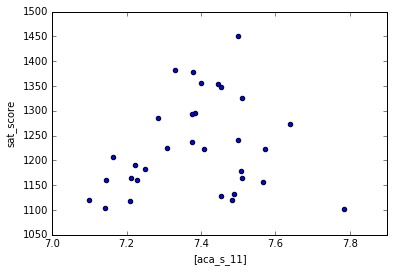

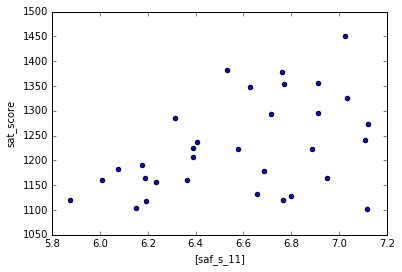

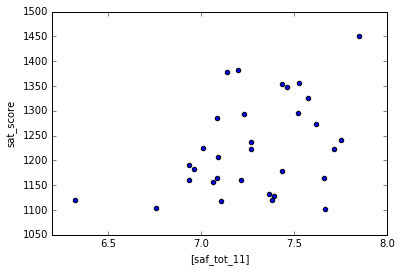

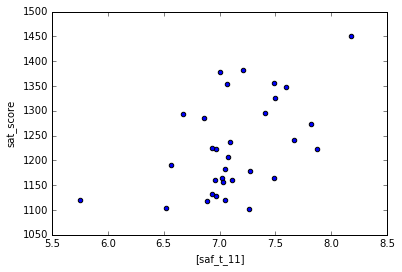

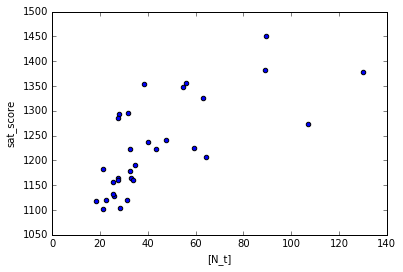

In [48]:
#bonus plot after merging school by districs, there seems to be a relation between the sat score and the number of respondent and the safety feeling 
for col in correlations[survey_fields].sort_values(ascending = False).index.str.split(',')[0:7]:
    districts.plot.scatter(x=col,y='sat_score')
    
    
    
    

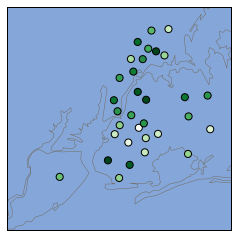

In [63]:
#drawing of the map of the district and colored by safety feeling

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044,  #setting coordinates of 2 corners of the map 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h' #intermediate res (crude, intermediate, higher and full)
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist() 
latitudes = districts['lat'].tolist()

m.scatter(longitudes,
          latitudes, #order very important !!! 
          s=50, #size 
          zorder=2, #to draw the plot over the continent 
          latlon=True,
          c=districts['saf_s_11'], #values which gonna be normalised [0:1] for coloration
          cmap='Greens'
         )
plt.show()

The safer, the grenner. 
There are some  disctricsts with a good dafety feeling  with some other feeling less safe like the districts of Brooklin and The Bronx north.

## Ethny and SAT Scores

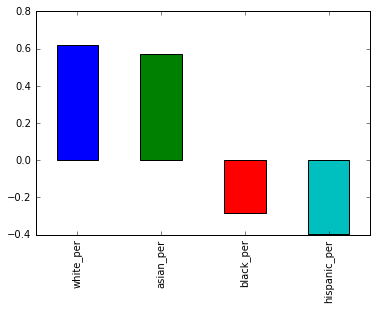

In [70]:
ethnies=['white_per','asian_per','black_per','hispanic_per']
correlations[ethnies].plot.bar()

-more white and asian linked to higher SAT scores and inverse for black and hispanic people. 
- these correlations are unfortunately  in line with the stereotypes, but are they true?? 

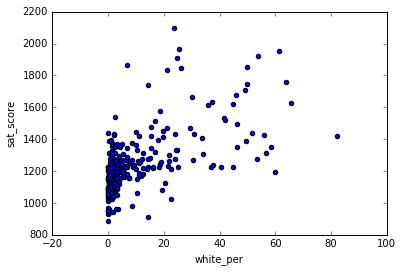

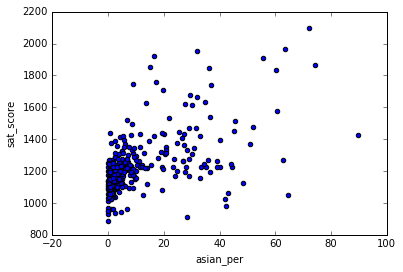

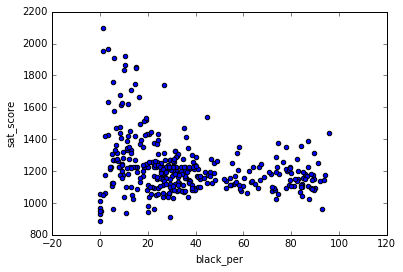

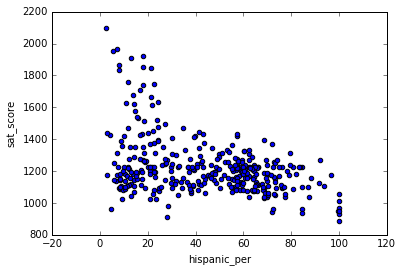

In [71]:
#plot the per of ethnies vs SAT scores
for ethny in ethnies:
    combined.plot.scatter(x=ethny, y='sat_score')

-the plot of the sat score vs the hispanic per shows a cluster with very high per of hispanics and low sat score. 

In [88]:
#school with >95% hispanics
combined[combined['hispanic_per']>95][['hispanic_per','SCHOOL NAME']].sort_values('hispanic_per',ascending=False)

,hispanic_per,SCHOOL NAME
286,100.0,PAN AMERICAN INTERNATIONAL HIGH SCHOOL
44,99.8,MANHATTAN BRIDGES HIGH SCHOOL
89,99.8,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
141,99.8,INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176,99.8,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253,99.8,MULTICULTURAL HIGH SCHOOL
125,99.4,ACADEMY FOR LANGUAGE AND TECHNOLOGY
82,96.7,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL


In [92]:
#school with low hispanic per and high sat score 
combined[(combined['hispanic_per'] <10) & (combined['sat_score'] >1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

School specialised in Science

## Genders and SAT score 

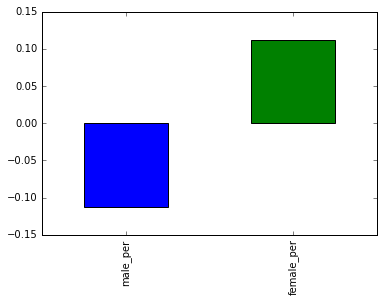

In [98]:
genders= ['male_per','female_per']
correlations[genders].plot.bar()

The correlation values are low so not nothing to observe based on that but if we plot.... 

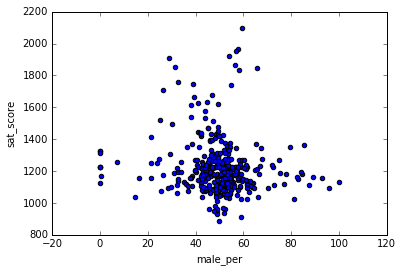

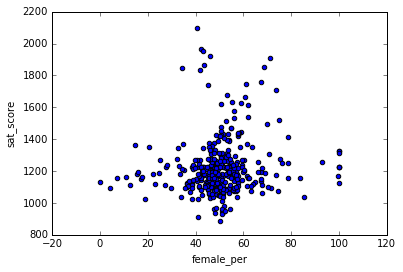

In [99]:
#gender per vs sat score 
for gender in genders:
    combined.plot.scatter(genders, 'sat_score')

As expected, the distribution is normal. There a cluster of high felames per and low sat score

In [101]:
combined[(combined['female_per'] >60) & (combined['sat_score'] >1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

## AP score vs SAT scores

In [104]:
combined['ap_per']= combined['AP Test Takers '] / combined['total_enrollment']

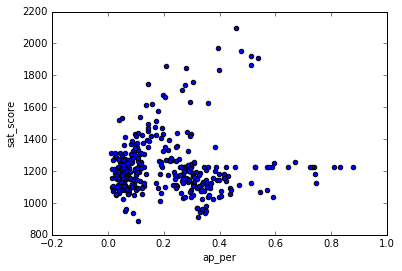

In [105]:
combined.plot.scatter('ap_per','sat_score')

Based on the plot, 2 observations:
- yes there a series where a higher Ap score correlated with SAT score so taking these exams have an influence on your SAT exam but 
- there is a series where the AP scores increase but the SAT score seats at arond 1250 ? why? does it mean they take AP exams but but their SAT Score does not improve.... domain knowledge is key to analyse that.  

#### going furhter:
We've done quite a bit of investigation into relationships between demographics and SAT scores in this guided project. There's still quite a bit of analysis left to do, however. Here are some potential next steps:

- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
    - If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.